## 역세권 피처 추가

In [125]:
#강제 새로고침
import importlib
import base_model_utils
importlib.reload(base_model_utils)
from base_model_utils import set_korean_font, preprocess_base_df, train_compare_models, plot_dealamount_correlation, clean_numeric_df


In [126]:
# df_cleaned = preprocess_base_df(df)
# model = train_and_compare_models(df, features = ['excluUseAr', 'floor', 'buildingAge', 'deal_quarter', 'umdNm',
#             'is_high_floor', 'subway_distance', 'isStationNearby'])
# train_and_compare_models(df_cleaned, features)

In [127]:
set_korean_font()

In [128]:
import pandas as pd
base_model_df = pd.read_csv('01_base_model_df.csv')
df_cleaned = preprocess_base_df(base_model_df)
df = df_cleaned.copy()

In [129]:
df.head(3)

,aptDong,aptNm,buildYear,buyerGbn,cdealDay,cdealType,dealAmount,dealDay,dealMonth,dealYear,...,jibun,landLeaseholdGbn,rgstDate,sggCd,slerGbn,umdNm,buildingAge,isHighFloor,dealYearMonth,dealQuarter
0,306,우장산롯데캐슬,2003,개인,,,110000,29,3,2025,...,1145,N,25.07.01,11500,개인,화곡동,22,0,2025-03,1
1,,청솔102동,1997,개인,,,56991,17,3,2025,...,673-14,N,25.07.01,11500,개인,내발산동,28,0,2025-03,1
2,,강변,1992,개인,,,73000,29,3,2025,...,1475,N,,11500,개인,가양동,33,0,2025-03,1


In [130]:
# estateAgentSggNm에서 첫 번째 주소만 사용하도록 정제
df['estateAgentSggNmClean'] = df['estateAgentSggNm'].str.split(',').str[0]
df['aptAddress'] = df['estateAgentSggNmClean'] + ' ' + df['umdNm'] + ' ' + df['jibun'].astype(str)
df['aptAddress']

0       서울 강서구 화곡동 1145
1           내발산동 673-14
2       서울 강서구 가양동 1475
3      서울 강서구 마곡동 743-4
4       서울 강서구 내발산동 753
             ...       
456    서울 강서구 등촌동 634-2
457    서울 강서구 화곡동 926-5
458      서울 강서구 등촌동 688
459     서울 강서구 가양동 1475
460     서울 강서구 마곡동 1360
Name: aptAddress, Length: 461, dtype: object

In [132]:
import requests
import time
from dotenv import load_dotenv
import os
from tqdm import tqdm

# 1. 환경변수 로딩
load_dotenv()
KAKAO_API_KEY = os.getenv('KAKAO_API_KEY')
headers = {'Authorization': f'KakaoAK {KAKAO_API_KEY}'}

# 2. 주소 → 좌표 변환 함수
def get_coords(address):
    url = 'https://dapi.kakao.com/v2/local/search/address.json'
    params = {'query': address}
    res = requests.get(url, headers=headers, params=params).json()
    try:
        coords = res['documents'][0]['address']
        return float(coords['y']), float(coords['x'])  # 위도, 경도
    except:
        return None

# 3. 지하철역 조회 함수 (반경 500m)
def is_nearby_subway(lat, lng, radius=500):
    url = 'https://dapi.kakao.com/v2/local/search/category.json'
    params = {
        'category_group_code': 'SW8',
        'x': lng,
        'y': lat,
        'radius': radius,
        'sort': 'distance'
    }
    res = requests.get(url, headers=headers, params=params).json()
    return len(res.get('documents', [])) > 0  # 하나라도 있으면 True

# 4. 적용 코드
apt_lat = []
apt_lng = []
subway_distance_list = []
isStationNearby_list = []

for i, addr in tqdm(enumerate(df['aptAddress']), total=len(df)):
    apt_name = df.iloc[i]['aptNm']
    coords = get_coords(addr)

    if coords:
        lat, lng = coords
        apt_lat.append(lat)
        apt_lng.append(lng)

        subways = get_nearby_subway(lat, lng)
        if subways:
            dist = int(subways[0]['distance'])
            subway_distance_list.append(dist)
            isStationNearby_list.append(dist <= 500)
        else:
            subway_distance_list.append(None)
            isStationNearby_list.append(False)
    else:
        apt_lat.append(None)
        apt_lng.append(None)
        subway_distance_list.append(None)
        isStationNearby_list.append(False)

    print(f"{apt_name} ({addr}) → 역세권 여부: {isStationNearby_list[-1]}")
    time.sleep(0.5)

# 길이 확인
print(len(df), len(apt_lat), len(isStationNearby_list))

  0%|                                                   | 0/461 [00:00<?, ?it/s]

우장산롯데캐슬 (서울 강서구 화곡동 1145) → 역세권 여부: False


  0%|                                           | 1/461 [00:00<05:20,  1.44it/s]

청솔102동 (  내발산동 673-14) → 역세권 여부: False


  0%|▏                                          | 2/461 [00:01<05:33,  1.38it/s]

강변 (서울 강서구 가양동 1475) → 역세권 여부: True


  1%|▎                                          | 3/461 [00:02<05:17,  1.44it/s]

마곡엠밸리7단지 (서울 강서구 마곡동 743-4) → 역세권 여부: True


  1%|▎                                          | 4/461 [00:02<05:52,  1.30it/s]

마곡수명산파크4단지 (서울 강서구 내발산동 753) → 역세권 여부: False


  1%|▍                                          | 5/461 [00:03<05:42,  1.33it/s]

등촌동아이파크 (서울 강서구 등촌동 715) → 역세권 여부: False


  1%|▌                                          | 6/461 [00:04<05:24,  1.40it/s]

강서쌍용예가 (서울 강서구 염창동 308) → 역세권 여부: False


  2%|▋                                          | 7/461 [00:05<05:24,  1.40it/s]

요산페어뷰 (서울 강서구 화곡동 377-21) → 역세권 여부: False


  2%|▋                                          | 8/461 [00:05<05:13,  1.44it/s]

신동아 (서울 강서구 염창동 289) → 역세권 여부: False


  2%|▊                                          | 9/461 [00:06<05:42,  1.32it/s]

주공3 (서울 강서구 등촌동 688) → 역세권 여부: True


  2%|▉                                         | 10/461 [00:07<05:28,  1.37it/s]

마곡금호어울림 (서울 강서구 마곡동 717) → 역세권 여부: False


  2%|█                                         | 11/461 [00:07<05:20,  1.40it/s]

강변한솔솔파크 (서울 강서구 염창동 300) → 역세권 여부: False


  3%|█                                         | 12/461 [00:08<05:38,  1.33it/s]

스위트드림아파트 (서울 강서구 화곡동 1168) → 역세권 여부: True


  3%|█▏                                        | 13/461 [00:09<05:26,  1.37it/s]

요산페어뷰 (서울 강서구 화곡동 377-21) → 역세권 여부: False


  3%|█▎                                        | 14/461 [00:10<05:40,  1.31it/s]

마곡엠벨리(14단지) (서울 강서구 마곡동 750) → 역세권 여부: True


  3%|█▎                                        | 15/461 [00:10<05:26,  1.37it/s]

초록 (서울 강서구 화곡동 1139) → 역세권 여부: True


  3%|█▍                                        | 16/461 [00:11<05:49,  1.27it/s]

가양강나루현대 (서울 강서구 가양동 448-1) → 역세권 여부: True


  4%|█▌                                        | 17/461 [00:12<05:34,  1.33it/s]

가양강나루현대 (서울 강서구 가양동 448-1) → 역세권 여부: True


  4%|█▋                                        | 18/461 [00:13<05:49,  1.27it/s]

마곡엠밸리10단지 (서울 강서구 마곡동 747) → 역세권 여부: True


  4%|█▋                                        | 19/461 [00:14<05:35,  1.32it/s]

동성 (서울 강서구 방화동 817) → 역세권 여부: True


  4%|█▊                                        | 20/461 [00:14<05:46,  1.27it/s]

태영 (  염창동 270-1) → 역세권 여부: True


  5%|█▉                                        | 21/461 [00:15<05:27,  1.34it/s]

가양6단지 (서울 강서구 가양동 1485) → 역세권 여부: True


  5%|██                                        | 22/461 [00:16<05:24,  1.35it/s]

신마곡벽산블루밍 (  방화동 904) → 역세권 여부: True


  5%|██                                        | 23/461 [00:17<05:44,  1.27it/s]

화곡1차보람더하임 (  화곡동 1087) → 역세권 여부: False


  5%|██▏                                       | 24/461 [00:17<05:35,  1.30it/s]

NS파크APT (서울 강서구 화곡동 1076-9) → 역세권 여부: True


  5%|██▎                                       | 25/461 [00:18<05:18,  1.37it/s]

가양6단지 (서울 강서구 가양동 1485) → 역세권 여부: True


  6%|██▎                                       | 26/461 [00:19<05:07,  1.42it/s]

우장산롯데캐슬 (서울 강서구 화곡동 1145) → 역세권 여부: False


  6%|██▍                                       | 27/461 [00:19<05:05,  1.42it/s]

빛고을우방 (서울 강서구 가양동 448-9) → 역세권 여부: True


  6%|██▌                                       | 28/461 [00:20<04:59,  1.45it/s]

강변 (서울 강서구 가양동 1475) → 역세권 여부: True


  6%|██▋                                       | 29/461 [00:21<04:52,  1.48it/s]

동아3 (서울 강서구 염창동 258-1) → 역세권 여부: True


  7%|██▋                                       | 30/461 [00:21<04:50,  1.48it/s]

동아3 (서울 강서구 염창동 258-1) → 역세권 여부: True


  7%|██▊                                       | 31/461 [00:22<04:43,  1.52it/s]

가양6단지 (서울 강서구 가양동 1485) → 역세권 여부: True


  7%|██▉                                       | 32/461 [00:23<04:38,  1.54it/s]

우장산타워빌 (서울 강서구 내발산동 704-2) → 역세권 여부: True


  7%|███                                       | 33/461 [00:23<04:35,  1.55it/s]

길성그랑프리텔 (서울 강서구 방화동 867) → 역세권 여부: True


  7%|███                                       | 34/461 [00:24<04:34,  1.56it/s]

삼정그린코아 (서울 강서구 염창동 282) → 역세권 여부: True


  8%|███▏                                      | 35/461 [00:25<04:43,  1.50it/s]

세한(410-150) (서울 강서구 화곡동 410-150) → 역세권 여부: False


  8%|███▎                                      | 36/461 [00:25<04:44,  1.49it/s]

마곡에이치밸리움 (서울 강서구 내발산동 764) → 역세권 여부: False


  8%|███▎                                      | 37/461 [00:26<04:44,  1.49it/s]

삼성하나로 (서울 강서구 염창동 248-3) → 역세권 여부: False


  8%|███▍                                      | 38/461 [00:27<04:48,  1.47it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


  8%|███▌                                      | 39/461 [00:27<04:44,  1.48it/s]

무학 (서울 강서구 염창동 255) → 역세권 여부: False


  9%|███▋                                      | 40/461 [00:28<04:44,  1.48it/s]

가양2단지(성지) (경기 남양주시 가양동 1461) → 역세권 여부: False


  9%|███▋                                      | 41/461 [00:29<04:29,  1.56it/s]

성재센트리움아파트(343-35) (  화곡동 343-35) → 역세권 여부: True


  9%|███▊                                      | 42/461 [00:29<04:34,  1.53it/s]

우장산롯데 (서울 강서구 화곡동 1148) → 역세권 여부: False


  9%|███▉                                      | 43/461 [00:30<04:34,  1.53it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 10%|████                                      | 44/461 [00:31<04:37,  1.50it/s]

가양2단지(성지) (서울 강서구 가양동 1461) → 역세권 여부: False


 10%|████                                      | 45/461 [00:31<04:52,  1.42it/s]

강변한솔솔파크 (서울 강서구 염창동 300) → 역세권 여부: False


 10%|████▏                                     | 46/461 [00:32<04:52,  1.42it/s]

등촌7,8단지주공아파트 (서울 강서구 등촌동 707) → 역세권 여부: True


 10%|████▎                                     | 47/461 [00:33<04:53,  1.41it/s]

강변 (서울 강서구 가양동 1475) → 역세권 여부: True


 10%|████▎                                     | 48/461 [00:34<04:48,  1.43it/s]

등촌동아이파크 (서울 강서구 등촌동 715) → 역세권 여부: False


 11%|████▍                                     | 49/461 [00:34<04:46,  1.44it/s]

무학 (서울 강서구 염창동 255) → 역세권 여부: False


 11%|████▌                                     | 50/461 [00:35<04:38,  1.48it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 11%|████▋                                     | 51/461 [00:36<04:33,  1.50it/s]

마곡엠벨리(14단지) (서울 강서구 마곡동 750) → 역세권 여부: True


 11%|████▋                                     | 52/461 [00:36<04:34,  1.49it/s]

빛고을우방 (서울 강서구 가양동 448-9) → 역세권 여부: True


 11%|████▊                                     | 53/461 [00:37<04:30,  1.51it/s]

마곡중앙하이츠아파트 (서울 강서구 방화동 852) → 역세권 여부: True


 12%|████▉                                     | 54/461 [00:37<04:28,  1.52it/s]

강변 (서울 강서구 가양동 1475) → 역세권 여부: True


 12%|█████                                     | 55/461 [00:38<04:25,  1.53it/s]

방화3차우림필유 (서울 강서구 방화동 546-1) → 역세권 여부: True


 12%|█████                                     | 56/461 [00:39<04:22,  1.54it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 12%|█████▏                                    | 57/461 [00:39<04:20,  1.55it/s]

염창동한강우성 (서울 강서구 염창동 66-9) → 역세권 여부: False


 13%|█████▎                                    | 58/461 [00:40<04:19,  1.55it/s]

화곡푸르지오 (서울 강서구 화곡동 1091) → 역세권 여부: False


 13%|█████▍                                    | 59/461 [00:41<04:18,  1.56it/s]

관음삼성 (서울 강서구 염창동 268) → 역세권 여부: True


 13%|█████▍                                    | 60/461 [00:41<04:16,  1.56it/s]

삼성하나로 (서울 강서구 염창동 248-3) → 역세권 여부: False


 13%|█████▌                                    | 61/461 [00:42<04:14,  1.57it/s]

주공3 (서울 강서구 등촌동 688) → 역세권 여부: True


 13%|█████▋                                    | 62/461 [00:43<04:11,  1.58it/s]

가양강나루현대 (서울 강서구 가양동 448-1) → 역세권 여부: True


 14%|█████▋                                    | 63/461 [00:43<04:11,  1.58it/s]

가양6단지 (서울 강서구 가양동 1485) → 역세권 여부: True


 14%|█████▊                                    | 64/461 [00:44<04:09,  1.59it/s]

현대1 (서울 강서구 염창동 288) → 역세권 여부: False


 14%|█████▉                                    | 65/461 [00:44<04:11,  1.58it/s]

청솔 (서울 강서구 방화동 832) → 역세권 여부: True


 14%|██████                                    | 66/461 [00:45<04:13,  1.56it/s]

한진로즈힐 (서울 강서구 방화동 579) → 역세권 여부: False


 15%|██████                                    | 67/461 [00:46<04:12,  1.56it/s]

염창3차보람 (서울 강서구 염창동 301) → 역세권 여부: False


 15%|██████▏                                   | 68/461 [00:46<04:13,  1.55it/s]

강변 (서울 강서구 가양동 1475) → 역세권 여부: True


 15%|██████▎                                   | 69/461 [00:47<04:10,  1.56it/s]

부영 (서울 강서구 등촌동 691-3) → 역세권 여부: False


 15%|██████▍                                   | 70/461 [00:48<04:09,  1.57it/s]

강변한솔솔파크 (서울 강서구 염창동 300) → 역세권 여부: False


 15%|██████▍                                   | 71/461 [00:48<04:07,  1.57it/s]

장미 (서울 강서구 방화동 841) → 역세권 여부: False


 16%|██████▌                                   | 72/461 [00:49<04:09,  1.56it/s]

방화그린 (서울 강서구 방화동 839) → 역세권 여부: False


 16%|██████▋                                   | 73/461 [00:50<04:07,  1.57it/s]

강서쌍용예가 (서울 강서구 염창동 308) → 역세권 여부: False


 16%|██████▋                                   | 74/461 [00:50<04:05,  1.57it/s]

강변 (서울 강서구 가양동 1475) → 역세권 여부: True


 16%|██████▊                                   | 75/461 [00:51<04:05,  1.57it/s]

마곡서광(치현마을) (서울 강서구 방화동 860) → 역세권 여부: False


 16%|██████▉                                   | 76/461 [00:51<04:05,  1.57it/s]

이너스내안에 (서울 강서구 염창동 254-2) → 역세권 여부: True


 17%|███████                                   | 77/461 [00:52<04:05,  1.57it/s]

방신서광 (서울 강서구 방화동 871) → 역세권 여부: True


 17%|███████                                   | 78/461 [00:53<04:04,  1.57it/s]

가양우성 (서울 강서구 가양동 14-3) → 역세권 여부: True


 17%|███████▏                                  | 79/461 [00:53<04:04,  1.56it/s]

주공5 (서울 강서구 등촌동 695) → 역세권 여부: False


 17%|███████▎                                  | 80/461 [00:54<04:03,  1.56it/s]

가양우성 (서울 강서구 가양동 14-3) → 역세권 여부: True


 18%|███████▍                                  | 81/461 [00:55<04:01,  1.57it/s]

신송타워 (서울 강서구 등촌동 662-3) → 역세권 여부: False


 18%|███████▍                                  | 82/461 [00:55<04:02,  1.56it/s]

동성 (서울 강서구 방화동 817) → 역세권 여부: True


 18%|███████▌                                  | 83/461 [00:56<04:02,  1.56it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 18%|███████▋                                  | 84/461 [00:57<04:00,  1.57it/s]

부영 (서울 강서구 등촌동 691-3) → 역세권 여부: False


 18%|███████▋                                  | 85/461 [00:57<03:59,  1.57it/s]

스위트드림아파트 (서울 강서구 화곡동 1168) → 역세권 여부: True


 19%|███████▊                                  | 86/461 [00:58<03:58,  1.57it/s]

벽산 (서울 강서구 마곡동 429) → 역세권 여부: False


 19%|███████▉                                  | 87/461 [00:59<03:56,  1.58it/s]

성재센트리움아파트 (서울 강서구 화곡동 143-11) → 역세권 여부: True


 19%|████████                                  | 88/461 [00:59<03:56,  1.58it/s]

방화5 (서울 강서구 방화동 814) → 역세권 여부: True


 19%|████████                                  | 89/461 [01:00<03:58,  1.56it/s]

가양6단지 (서울 강서구 가양동 1485) → 역세권 여부: True


 20%|████████▏                                 | 90/461 [01:00<03:55,  1.58it/s]

화곡푸르지오 (서울 양천구 화곡동 1091) → 역세권 여부: False


 20%|████████▎                                 | 91/461 [01:01<03:46,  1.63it/s]

가양2단지(성지) (서울 강서구 가양동 1461) → 역세권 여부: False


 20%|████████▍                                 | 92/461 [01:02<03:48,  1.62it/s]

서부인터빌아파트 (서울 강서구 화곡동 1074-18) → 역세권 여부: True


 20%|████████▍                                 | 93/461 [01:02<03:50,  1.60it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 20%|████████▌                                 | 94/461 [01:03<03:50,  1.59it/s]

마곡엠밸리7단지 (서울 강서구 마곡동 743-4) → 역세권 여부: True


 21%|████████▋                                 | 95/461 [01:04<03:50,  1.59it/s]

방화5 (서울 강서구 방화동 814) → 역세권 여부: True


 21%|████████▋                                 | 96/461 [01:04<03:50,  1.58it/s]

동성 (서울 강서구 방화동 817) → 역세권 여부: True


 21%|████████▊                                 | 97/461 [01:05<03:49,  1.58it/s]

가양강나루현대 (서울 강서구 가양동 448-1) → 역세권 여부: True


 21%|████████▉                                 | 98/461 [01:06<04:01,  1.50it/s]

태승훼미리아파트5차 (서울 강서구 내발산동 714-4) → 역세권 여부: True


 21%|█████████                                 | 99/461 [01:06<04:03,  1.48it/s]

청솔 (서울 강서구 방화동 832) → 역세권 여부: True


 22%|████████▉                                | 100/461 [01:07<04:08,  1.45it/s]

성원 (서울 강서구 염창동 295) → 역세권 여부: False


 22%|████████▉                                | 101/461 [01:08<04:11,  1.43it/s]

동아 (서울 강서구 염창동 292) → 역세권 여부: False


 22%|█████████                                | 102/461 [01:08<04:13,  1.41it/s]

강변 (서울 강서구 가양동 1475) → 역세권 여부: True


 22%|█████████▏                               | 103/461 [01:09<04:06,  1.45it/s]

동부센트레빌 (서울 강서구 방화동 870) → 역세권 여부: True


 23%|█████████▏                               | 104/461 [01:10<04:07,  1.44it/s]

마곡13단지힐스테이트마스터 (서울 강서구 마곡동 748) → 역세권 여부: False


 23%|█████████▎                               | 105/461 [01:10<04:03,  1.46it/s]

부영 (부산 부산진구 등촌동 691-3) → 역세권 여부: False


 23%|█████████▍                               | 106/461 [01:11<03:56,  1.50it/s]

마곡엠밸리5단지 (서울 강서구 마곡동 740) → 역세권 여부: True


 23%|█████████▌                               | 107/461 [01:12<04:03,  1.45it/s]

가양2단지(성지) (서울 강서구 가양동 1461) → 역세권 여부: False


 23%|█████████▌                               | 108/461 [01:12<03:59,  1.48it/s]

강서월드메르디앙 (서울 강서구 내발산동 659-1) → 역세권 여부: False


 24%|█████████▋                               | 109/461 [01:13<03:57,  1.48it/s]

삼정그린코아 (서울 강서구 염창동 282) → 역세권 여부: True


 24%|█████████▊                               | 110/461 [01:14<03:53,  1.50it/s]

서광등촌마을아파트 (서울 강서구 등촌동 638) → 역세권 여부: True


 24%|█████████▊                               | 111/461 [01:14<03:55,  1.48it/s]

동아3 (서울 강서구 염창동 258-1) → 역세권 여부: True


 24%|█████████▉                               | 112/461 [01:15<03:53,  1.50it/s]

우장산아이파크,이편한세상 (서울 강서구 화곡동 1159) → 역세권 여부: True


 25%|██████████                               | 113/461 [01:16<03:59,  1.46it/s]

마곡수명산파크4단지 (서울 강서구 내발산동 753) → 역세권 여부: False


 25%|██████████▏                              | 114/461 [01:16<03:57,  1.46it/s]

요산페어뷰 (서울 강서구 화곡동 377-21) → 역세권 여부: False


 25%|██████████▏                              | 115/461 [01:17<03:57,  1.46it/s]

강변한솔솔파크 (서울 강서구 염창동 300) → 역세권 여부: False


 25%|██████████▎                              | 116/461 [01:18<03:54,  1.47it/s]

우장산힐스테이트 (서울 강서구 내발산동 657) → 역세권 여부: True


 25%|██████████▍                              | 117/461 [01:18<03:51,  1.49it/s]

가양2단지(성지) (서울 강서구 가양동 1461) → 역세권 여부: False


 26%|██████████▍                              | 118/461 [01:19<04:00,  1.43it/s]

마곡13단지힐스테이트마스터 (서울 강서구 마곡동 748) → 역세권 여부: False


 26%|██████████▌                              | 119/461 [01:20<03:58,  1.43it/s]

삼성한아름 (서울 강서구 염창동 264-27) → 역세권 여부: True


 26%|██████████▋                              | 120/461 [01:21<03:52,  1.47it/s]

마곡중앙하이츠아파트 (서울 강서구 방화동 852) → 역세권 여부: True


 26%|██████████▊                              | 121/461 [01:21<03:51,  1.47it/s]

등촌7,8단지주공아파트 (서울 강서구 등촌동 707) → 역세권 여부: True


 26%|██████████▊                              | 122/461 [01:22<03:46,  1.49it/s]

동아3 (서울 강서구 염창동 258-1) → 역세권 여부: True


 27%|██████████▉                              | 123/461 [01:23<03:47,  1.49it/s]

마곡엠밸리8단지 (서울 강서구 마곡동 741) → 역세권 여부: True


 27%|███████████                              | 124/461 [01:23<03:43,  1.51it/s]

태영 (서울 강서구 등촌동 632-2) → 역세권 여부: True


 27%|███████████                              | 125/461 [01:24<03:46,  1.49it/s]

남광아파트 (서울 강서구 화곡동 920-15) → 역세권 여부: True


 27%|███████████▏                             | 126/461 [01:25<03:48,  1.47it/s]

미주 (서울 강서구 화곡동 474-1) → 역세권 여부: False


 28%|███████████▎                             | 127/461 [01:25<03:44,  1.49it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 28%|███████████▍                             | 128/461 [01:26<03:53,  1.43it/s]

주공3 (서울 강서구 등촌동 688) → 역세권 여부: True


 28%|███████████▍                             | 129/461 [01:27<03:54,  1.42it/s]

우장산아이파크,이편한세상 (서울 강서구 화곡동 1159) → 역세권 여부: True


 28%|███████████▌                             | 130/461 [01:27<03:46,  1.46it/s]

강서센트레빌3차(894-0) (  방화동 894) → 역세권 여부: True


 28%|███████████▋                             | 131/461 [01:28<03:44,  1.47it/s]

주공10 (서울 강서구 등촌동 702) → 역세권 여부: False


 29%|███████████▋                             | 132/461 [01:29<03:42,  1.48it/s]

롯데2 (서울 강서구 내발산동 729) → 역세권 여부: False


 29%|███████████▊                             | 133/461 [01:29<03:38,  1.50it/s]

마곡중앙하이츠아파트 (서울 강서구 방화동 852) → 역세권 여부: True


 29%|███████████▉                             | 134/461 [01:30<03:36,  1.51it/s]

극동상록수 (서울 강서구 염창동 280) → 역세권 여부: True


 29%|████████████                             | 135/461 [01:31<03:42,  1.47it/s]

동부센트레빌 (서울 강서구 방화동 870) → 역세권 여부: True


 30%|████████████                             | 136/461 [01:32<03:50,  1.41it/s]

극동 (서울 강서구 염창동 246-23) → 역세권 여부: False


 30%|████████████▏                            | 137/461 [01:32<03:47,  1.42it/s]

방화5 (서울 강서구 방화동 814) → 역세권 여부: True


 30%|████████████▎                            | 138/461 [01:33<04:27,  1.21it/s]

주공3 (서울 강서구 등촌동 688) → 역세권 여부: True


 30%|████████████▎                            | 139/461 [01:34<04:23,  1.22it/s]

마곡수명산파크3단지 (서울 강서구 내발산동 751) → 역세권 여부: False


 30%|████████████▍                            | 140/461 [01:35<04:21,  1.23it/s]

청솔 (서울 강서구 방화동 832) → 역세권 여부: True


 31%|████████████▌                            | 141/461 [01:36<04:10,  1.28it/s]

방신서광 (서울 강서구 방화동 871) → 역세권 여부: True


 31%|████████████▋                            | 142/461 [01:36<03:55,  1.36it/s]

우장산아이파크,이편한세상 (서울 강서구 화곡동 1159) → 역세권 여부: True


 31%|████████████▋                            | 143/461 [01:37<03:45,  1.41it/s]

마곡힐스테이트 (서울 강서구 마곡동 725-1) → 역세권 여부: True


 31%|████████████▊                            | 144/461 [01:38<03:37,  1.46it/s]

현대 (서울 강서구 등촌동 655-27) → 역세권 여부: False


 31%|████████████▉                            | 145/461 [01:38<03:32,  1.49it/s]

우장산아이파크,이편한세상 (서울 강서구 화곡동 1159) → 역세권 여부: True


 32%|████████████▉                            | 146/461 [01:39<03:28,  1.51it/s]

초록 (서울 강서구 화곡동 1139) → 역세권 여부: True


 32%|█████████████                            | 147/461 [01:39<03:24,  1.53it/s]

주공5 (  등촌동 695) → 역세권 여부: False


 32%|█████████████▏                           | 148/461 [01:40<03:22,  1.54it/s]

강서한강월드메르디앙 (서울 강서구 가양동 1462) → 역세권 여부: True


 32%|█████████████▎                           | 149/461 [01:41<03:20,  1.55it/s]

가양2단지(성지) (서울 강서구 가양동 1461) → 역세권 여부: False


 33%|█████████████▎                           | 150/461 [01:41<03:18,  1.57it/s]

방화그린 (서울 강서구 방화동 839) → 역세권 여부: False


 33%|█████████████▍                           | 151/461 [01:42<03:16,  1.58it/s]

가양2단지(성지) (서울 강서구 가양동 1461) → 역세권 여부: False


 33%|█████████████▌                           | 152/461 [01:43<03:16,  1.58it/s]

극동상록수 (서울 강서구 염창동 280) → 역세권 여부: True


 33%|█████████████▌                           | 153/461 [01:43<03:14,  1.58it/s]

드림시드아파트1차 (서울 강서구 화곡동 899-13) → 역세권 여부: True


 33%|█████████████▋                           | 154/461 [01:44<03:13,  1.59it/s]

신안 (서울 강서구 마곡동 422) → 역세권 여부: True


 34%|█████████████▊                           | 155/461 [01:45<03:12,  1.59it/s]

우장산롯데캐슬 (서울 강서구 화곡동 1145) → 역세권 여부: False


 34%|█████████████▊                           | 156/461 [01:45<03:12,  1.59it/s]

동신대아 (서울 강서구 가양동 1459) → 역세권 여부: True


 34%|█████████████▉                           | 157/461 [01:46<03:13,  1.57it/s]

마곡서광(치현마을) (서울 강서구 방화동 860) → 역세권 여부: False


 34%|██████████████                           | 158/461 [01:46<03:11,  1.58it/s]

마곡현대아파트 (경기 김포시 마곡동 1171) → 역세권 여부: False


 34%|██████████████▏                          | 159/461 [01:47<03:04,  1.63it/s]

롯데캐슬 (서울 강서구 염창동 272-11) → 역세권 여부: True


 35%|██████████████▏                          | 160/461 [01:48<03:07,  1.61it/s]

우장산힐스테이트 (서울 강서구 내발산동 657) → 역세권 여부: True


 35%|██████████████▎                          | 161/461 [01:48<03:07,  1.60it/s]

롯데캐슬 (서울 강서구 염창동 272-11) → 역세권 여부: True


 35%|██████████████▍                          | 162/461 [01:49<03:07,  1.59it/s]

마곡수명산파크5단지 (서울 강서구 내발산동 749) → 역세권 여부: False


 35%|██████████████▍                          | 163/461 [01:50<03:07,  1.59it/s]

가양도시개발9-2단지 (서울 강서구 가양동 1490) → 역세권 여부: True


 36%|██████████████▌                          | 164/461 [01:50<03:08,  1.58it/s]

우장산힐스테이트 (서울 강서구 내발산동 657) → 역세권 여부: True


 36%|██████████████▋                          | 165/461 [01:51<03:07,  1.58it/s]

서부인터빌아파트 (서울 강서구 화곡동 1074-18) → 역세권 여부: True


 36%|██████████████▊                          | 166/461 [01:51<03:05,  1.59it/s]

이너스내안에 (서울 강서구 염창동 254-2) → 역세권 여부: True


 36%|██████████████▊                          | 167/461 [01:52<03:04,  1.59it/s]

마곡엠밸리6단지 (서울 강서구 마곡동 743) → 역세권 여부: True


 36%|██████████████▉                          | 168/461 [01:53<03:04,  1.59it/s]

동아 (서울 강서구 염창동 292) → 역세권 여부: False


 37%|███████████████                          | 169/461 [01:53<03:09,  1.54it/s]

대림경동아파트 (서울 강서구 가양동 1474) → 역세권 여부: False


 37%|███████████████                          | 170/461 [01:54<03:09,  1.54it/s]

마곡중앙하이츠아파트 (경기 고양시 덕양구 방화동 852) → 역세권 여부: False


 37%|███████████████▏                         | 171/461 [01:55<03:01,  1.60it/s]

NS파크APT (서울 강서구 화곡동 1076-9) → 역세권 여부: True


 37%|███████████████▎                         | 172/461 [01:55<03:01,  1.59it/s]

우장산힐스테이트 (서울 강서구 내발산동 657) → 역세권 여부: True


 38%|███████████████▍                         | 173/461 [01:56<03:00,  1.60it/s]

주공10 (서울 강서구 등촌동 702) → 역세권 여부: False


 38%|███████████████▍                         | 174/461 [01:56<02:59,  1.60it/s]

마곡엠밸리8단지 (서울 강서구 마곡동 741) → 역세권 여부: True


 38%|███████████████▌                         | 175/461 [01:57<02:59,  1.60it/s]

강서월드메르디앙 (서울 강서구 내발산동 659-1) → 역세권 여부: False


 38%|███████████████▋                         | 176/461 [01:58<02:58,  1.60it/s]

등촌7,8단지주공아파트 (서울 강서구 등촌동 707) → 역세권 여부: True


 38%|███████████████▋                         | 177/461 [01:58<02:57,  1.60it/s]

한숲마을대림 (서울 강서구 방화동 862) → 역세권 여부: True


 39%|███████████████▊                         | 178/461 [01:59<02:58,  1.59it/s]

마곡수명산파크4단지 (서울 강서구 내발산동 753) → 역세권 여부: False


 39%|███████████████▉                         | 179/461 [02:00<02:57,  1.59it/s]

태청 (서울 강서구 방화동 319-9) → 역세권 여부: True


 39%|████████████████                         | 180/461 [02:00<02:57,  1.58it/s]

등촌동아이파크 (서울 강서구 등촌동 715) → 역세권 여부: False


 39%|████████████████                         | 181/461 [02:01<02:56,  1.59it/s]

강서한강자이 (서울 강서구 가양동 1500) → 역세권 여부: False


 39%|████████████████▏                        | 182/461 [02:02<02:59,  1.56it/s]

마곡중앙하이츠아파트 (서울 강서구 방화동 852) → 역세권 여부: True


 40%|████████████████▎                        | 183/461 [02:02<02:57,  1.57it/s]

주공10 (서울 강서구 등촌동 702) → 역세권 여부: False


 40%|████████████████▎                        | 184/461 [02:03<02:55,  1.58it/s]

가양6단지 (서울 강서구 가양동 1485) → 역세권 여부: True


 40%|████████████████▍                        | 185/461 [02:03<02:54,  1.58it/s]

가양도시개발9-2단지 (서울 강서구 가양동 1490) → 역세권 여부: True


 40%|████████████████▌                        | 186/461 [02:04<02:53,  1.59it/s]

방화그린 (서울 강서구 방화동 839) → 역세권 여부: False


 41%|████████████████▋                        | 187/461 [02:05<02:52,  1.59it/s]

한강타운 (서울 강서구 가양동 1460) → 역세권 여부: True


 41%|████████████████▋                        | 188/461 [02:05<02:53,  1.57it/s]

태영 (서울 강서구 염창동 270-1) → 역세권 여부: True


 41%|████████████████▊                        | 189/461 [02:06<02:53,  1.57it/s]

마곡수명산파크7단지 (서울 강서구 내발산동 756) → 역세권 여부: False


 41%|████████████████▉                        | 190/461 [02:07<02:52,  1.57it/s]

대림e편한세상 (서울 강서구 화곡동 361-1) → 역세권 여부: False


 41%|████████████████▉                        | 191/461 [02:07<02:52,  1.56it/s]

e편한세상염창 (서울 강서구 염창동 309) → 역세권 여부: True


 42%|█████████████████                        | 192/461 [02:08<02:51,  1.57it/s]

마곡중앙하이츠아파트 (서울 강서구 방화동 852) → 역세권 여부: True


 42%|█████████████████▏                       | 193/461 [02:09<02:49,  1.58it/s]

태진아름 (서울 강서구 등촌동 676) → 역세권 여부: True


 42%|█████████████████▎                       | 194/461 [02:09<02:49,  1.58it/s]

마곡수명산파크3단지 (  내발산동 751) → 역세권 여부: False


 42%|█████████████████▎                       | 195/461 [02:10<02:48,  1.58it/s]

가양도시개발9-2단지 (서울 강서구 가양동 1490) → 역세권 여부: True


 43%|█████████████████▍                       | 196/461 [02:10<02:47,  1.58it/s]

동아3 (서울 강서구 염창동 258-1) → 역세권 여부: True


 43%|█████████████████▌                       | 197/461 [02:11<02:46,  1.59it/s]

우장산아이파크,이편한세상 (서울 강서구 화곡동 1159) → 역세권 여부: True


 43%|█████████████████▌                       | 198/461 [02:12<02:45,  1.59it/s]

강변 (서울 강서구 가양동 1475) → 역세권 여부: True


 43%|█████████████████▋                       | 199/461 [02:12<02:43,  1.60it/s]

이너스내안에 (서울 강서구 염창동 254-2) → 역세권 여부: True


 43%|█████████████████▊                       | 200/461 [02:13<02:43,  1.59it/s]

마곡금호어울림 (서울 강서구 마곡동 717) → 역세권 여부: False


 44%|█████████████████▉                       | 201/461 [02:14<02:43,  1.59it/s]

이너스내안에 (서울 강서구 염창동 254-2) → 역세권 여부: True


 44%|█████████████████▉                       | 202/461 [02:14<02:42,  1.60it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 44%|██████████████████                       | 203/461 [02:15<02:42,  1.59it/s]

우장산숲아이파크 (서울 강서구 화곡동 1173) → 역세권 여부: True


 44%|██████████████████▏                      | 204/461 [02:15<02:41,  1.59it/s]

가양6단지 (서울 강서구 가양동 1485) → 역세권 여부: True


 44%|██████████████████▏                      | 205/461 [02:16<02:41,  1.59it/s]

극동 (서울 강서구 염창동 246-23) → 역세권 여부: False


 45%|██████████████████▎                      | 206/461 [02:17<02:39,  1.60it/s]

위하우스아파트 (서울 강서구 화곡동 916-2) → 역세권 여부: True


 45%|██████████████████▍                      | 207/461 [02:17<02:39,  1.59it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 45%|██████████████████▍                      | 208/461 [02:18<02:39,  1.59it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 45%|██████████████████▌                      | 209/461 [02:19<02:38,  1.59it/s]

등촌라인(조합) (서울 강남구 등촌동 628-15) → 역세권 여부: False


 46%|██████████████████▋                      | 210/461 [02:19<02:33,  1.64it/s]

마곡현대아파트 (경기 김포시 마곡동 1171) → 역세권 여부: False


 46%|██████████████████▊                      | 211/461 [02:20<02:29,  1.67it/s]

마곡청구아파트 (서울 강서구 마곡동 1181) → 역세권 여부: False


 46%|██████████████████▊                      | 212/461 [02:20<02:31,  1.64it/s]

강서쌍용예가 (서울 강서구 염창동 308) → 역세권 여부: False


 46%|██████████████████▉                      | 213/461 [02:21<02:33,  1.62it/s]

가양2단지(성지) (서울 강서구 가양동 1461) → 역세권 여부: False


 46%|███████████████████                      | 214/461 [02:22<02:33,  1.61it/s]

강서한강자이 (서울 강서구 가양동 1500) → 역세권 여부: False


 47%|███████████████████                      | 215/461 [02:22<02:33,  1.61it/s]

한강타운 (서울 강서구 가양동 1460) → 역세권 여부: True


 47%|███████████████████▏                     | 216/461 [02:23<02:33,  1.60it/s]

주공10 (서울 강서구 등촌동 702) → 역세권 여부: False


 47%|███████████████████▎                     | 217/461 [02:24<02:32,  1.60it/s]

마곡힐스테이트 (서울 강서구 마곡동 725-1) → 역세권 여부: True


 47%|███████████████████▍                     | 218/461 [02:24<02:31,  1.60it/s]

부영 (서울 강서구 등촌동 691-3) → 역세권 여부: False


 48%|███████████████████▍                     | 219/461 [02:25<02:30,  1.61it/s]

마곡서광(치현마을) (서울 강서구 방화동 860) → 역세권 여부: False


 48%|███████████████████▌                     | 220/461 [02:25<02:29,  1.61it/s]

마곡엠밸리4단지 (서울 강서구 마곡동 738) → 역세권 여부: True


 48%|███████████████████▋                     | 221/461 [02:26<02:30,  1.59it/s]

대림e-편한세상 (서울 강서구 방화동 874) → 역세권 여부: True


 48%|███████████████████▋                     | 222/461 [02:27<02:30,  1.59it/s]

성원 (서울 강서구 염창동 295) → 역세권 여부: False


 48%|███████████████████▊                     | 223/461 [02:27<02:29,  1.60it/s]

주공5 (  등촌동 695) → 역세권 여부: False


 49%|███████████████████▉                     | 224/461 [02:28<02:28,  1.59it/s]

가양6단지 (서울 강서구 가양동 1485) → 역세권 여부: True


 49%|████████████████████                     | 225/461 [02:29<02:28,  1.59it/s]

우장산롯데캐슬 (서울 강서구 화곡동 1145) → 역세권 여부: False


 49%|████████████████████                     | 226/461 [02:29<02:27,  1.59it/s]

성원 (서울 강서구 염창동 295) → 역세권 여부: False


 49%|████████████████████▏                    | 227/461 [02:30<02:26,  1.59it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 49%|████████████████████▎                    | 228/461 [02:30<02:26,  1.59it/s]

화곡푸르지오 (서울 강서구 화곡동 1091) → 역세권 여부: False


 50%|████████████████████▎                    | 229/461 [02:31<02:26,  1.58it/s]

강서힐스테이트 (경기 안양시 만안구 화곡동 1165) → 역세권 여부: False


 50%|████████████████████▍                    | 230/461 [02:32<02:21,  1.64it/s]

마곡청구아파트 (서울 강서구 마곡동 1181) → 역세권 여부: False


 50%|████████████████████▌                    | 231/461 [02:32<02:24,  1.59it/s]

우장산힐스테이트 (서울 강서구 내발산동 657) → 역세권 여부: True


 50%|████████████████████▋                    | 232/461 [02:33<02:23,  1.59it/s]

강서한강자이 (서울 강서구 가양동 1500) → 역세권 여부: False


 51%|████████████████████▋                    | 233/461 [02:34<02:26,  1.55it/s]

한미(286-1) (서울 강서구 방화동 286-1) → 역세권 여부: True


 51%|████████████████████▊                    | 234/461 [02:34<02:28,  1.53it/s]

우장산아이파크,이편한세상 (서울 강서구 화곡동 1159) → 역세권 여부: True


 51%|████████████████████▉                    | 235/461 [02:35<02:32,  1.48it/s]

화곡한강 (서울 강서구 화곡동 1059-19) → 역세권 여부: True


 51%|████████████████████▉                    | 236/461 [02:36<02:29,  1.50it/s]

유원펠리체(924-17) (서울 강서구 화곡동 924-17) → 역세권 여부: False


 51%|█████████████████████                    | 237/461 [02:36<02:27,  1.52it/s]

강서월드메르디앙 (서울 강서구 내발산동 659-1) → 역세권 여부: False


 52%|█████████████████████▏                   | 238/461 [02:37<02:24,  1.54it/s]

강변힐스테이트 (서울 강서구 염창동 299) → 역세권 여부: True


 52%|█████████████████████▎                   | 239/461 [02:38<02:22,  1.55it/s]

등촌1,2단지주공아파트 (서울 강서구 등촌동 687) → 역세권 여부: True


 52%|█████████████████████▎                   | 240/461 [02:38<02:21,  1.56it/s]

화곡푸르지오 (서울 양천구 화곡동 1091) → 역세권 여부: False


 52%|█████████████████████▍                   | 241/461 [02:39<02:15,  1.62it/s]

한강동아 (서울 강서구 염창동 293) → 역세권 여부: False


 52%|█████████████████████▌                   | 242/461 [02:39<02:17,  1.60it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 53%|█████████████████████▌                   | 243/461 [02:40<02:17,  1.58it/s]

탑건진선미 (서울 강서구 화곡동 1155) → 역세권 여부: True


 53%|█████████████████████▋                   | 244/461 [02:41<02:18,  1.56it/s]

계명위너스 (서울 영등포구 등촌동 646-29) → 역세권 여부: False


 53%|█████████████████████▊                   | 245/461 [02:41<02:13,  1.62it/s]

개화 (서울 강서구 방화동 819) → 역세권 여부: True


 53%|█████████████████████▉                   | 246/461 [02:42<02:15,  1.59it/s]

삼성하나로 (서울 강서구 염창동 248-3) → 역세권 여부: False


 54%|█████████████████████▉                   | 247/461 [02:43<02:15,  1.58it/s]

강변 (서울 강서구 가양동 1475) → 역세권 여부: True


 54%|██████████████████████                   | 248/461 [02:43<02:14,  1.58it/s]

동신대아 (서울 강서구 가양동 1459) → 역세권 여부: True


 54%|██████████████████████▏                  | 249/461 [02:44<02:13,  1.58it/s]

강변 (서울 강서구 가양동 1475) → 역세권 여부: True


 54%|██████████████████████▏                  | 250/461 [02:44<02:13,  1.58it/s]

가양6단지 (서울 강서구 가양동 1485) → 역세권 여부: True


 54%|██████████████████████▎                  | 251/461 [02:45<02:12,  1.58it/s]

마곡중앙하이츠아파트 (서울 강서구 방화동 852) → 역세권 여부: True


 55%|██████████████████████▍                  | 252/461 [02:46<02:12,  1.58it/s]

신안 (서울 강서구 마곡동 422) → 역세권 여부: True


 55%|██████████████████████▌                  | 253/461 [02:46<02:12,  1.57it/s]

신동아 (서울 강서구 염창동 289) → 역세권 여부: False


 55%|██████████████████████▌                  | 254/461 [02:47<02:10,  1.58it/s]

극동상록수 (서울 강서구 염창동 280) → 역세권 여부: True


 55%|██████████████████████▋                  | 255/461 [02:48<02:10,  1.57it/s]

가양6단지 (서울 강서구 가양동 1485) → 역세권 여부: True


 56%|██████████████████████▊                  | 256/461 [02:48<02:09,  1.58it/s]

마곡우림필유아파트 (서울 강서구 마곡동 1467) → 역세권 여부: False


 56%|██████████████████████▊                  | 257/461 [02:49<02:10,  1.56it/s]

개화 (서울 강서구 방화동 819) → 역세권 여부: True


 56%|██████████████████████▉                  | 258/461 [02:50<02:09,  1.57it/s]

강변월드메르디앙 (서울 강서구 염창동 240-1) → 역세권 여부: True


 56%|███████████████████████                  | 259/461 [02:50<02:08,  1.57it/s]

e편한세상염창 (서울 강서구 염창동 309) → 역세권 여부: True


 56%|███████████████████████                  | 260/461 [02:51<02:07,  1.57it/s]

NS파크APT (서울 강서구 화곡동 1076-9) → 역세권 여부: True


 57%|███████████████████████▏                 | 261/461 [02:51<02:07,  1.57it/s]

염창3우성 (서울 양천구 염창동 272-28) → 역세권 여부: False


 57%|███████████████████████▎                 | 262/461 [02:52<02:02,  1.63it/s]

예스빌 (서울 강서구 내발산동 687-2) → 역세권 여부: False


 57%|███████████████████████▍                 | 263/461 [02:53<02:03,  1.61it/s]

동아 (서울 강서구 염창동 292) → 역세권 여부: False


 57%|███████████████████████▍                 | 264/461 [02:53<02:03,  1.59it/s]

주공3 (서울 강서구 등촌동 688) → 역세권 여부: True


 57%|███████████████████████▌                 | 265/461 [02:54<02:11,  1.49it/s]

가양6단지 (서울 강서구 가양동 1485) → 역세권 여부: True


 58%|███████████████████████▋                 | 266/461 [02:55<02:25,  1.34it/s]

한진로즈힐 (서울 강서구 방화동 579) → 역세권 여부: False


 58%|███████████████████████▋                 | 267/461 [02:56<02:21,  1.38it/s]

마곡13단지힐스테이트마스터 (서울 강서구 마곡동 748) → 역세권 여부: False


 58%|███████████████████████▊                 | 268/461 [02:56<02:17,  1.40it/s]

마곡엠벨리(15단지) (서울 강서구 마곡동 751) → 역세권 여부: True


 58%|███████████████████████▉                 | 269/461 [02:57<02:15,  1.42it/s]

마곡13단지힐스테이트마스터 (서울 강서구 마곡동 748) → 역세권 여부: False


 59%|████████████████████████                 | 270/461 [02:58<02:14,  1.42it/s]

일성스카이빌 (서울 강서구 화곡동 914-3) → 역세권 여부: True


 59%|████████████████████████                 | 271/461 [02:58<02:11,  1.45it/s]

동아3 (서울 강서구 염창동 258-1) → 역세권 여부: True


 59%|████████████████████████▏                | 272/461 [02:59<02:07,  1.48it/s]

벽산 (서울 강서구 마곡동 429) → 역세권 여부: False


 59%|████████████████████████▎                | 273/461 [03:00<02:05,  1.50it/s]

메종드로제 (서울 강서구 화곡동 926-3) → 역세권 여부: True


 59%|████████████████████████▎                | 274/461 [03:00<02:03,  1.51it/s]

신동아 (서울 강서구 방화동 796) → 역세권 여부: True


 60%|████████████████████████▍                | 275/461 [03:01<02:01,  1.52it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 60%|████████████████████████▌                | 276/461 [03:02<02:00,  1.54it/s]

우장산힐스테이트 (서울 강서구 내발산동 657) → 역세권 여부: True


 60%|████████████████████████▋                | 277/461 [03:02<01:58,  1.56it/s]

우장산아이파크,이편한세상 (서울 강서구 화곡동 1159) → 역세권 여부: True


 60%|████████████████████████▋                | 278/461 [03:03<01:57,  1.55it/s]

가양2단지(성지) (서울 강서구 가양동 1461) → 역세권 여부: False


 61%|████████████████████████▊                | 279/461 [03:04<01:57,  1.55it/s]

염창1차한화꿈에그린 (서울 강서구 염창동 281-22) → 역세권 여부: True


 61%|████████████████████████▉                | 280/461 [03:04<01:56,  1.56it/s]

현대 (서울 강서구 방화동 793) → 역세권 여부: True


 61%|████████████████████████▉                | 281/461 [03:05<01:55,  1.56it/s]

가양2단지(성지) (서울 강서구 가양동 1461) → 역세권 여부: False


 61%|█████████████████████████                | 282/461 [03:05<01:54,  1.56it/s]

강서한강자이 (서울 강서구 가양동 1500) → 역세권 여부: False


 61%|█████████████████████████▏               | 283/461 [03:06<01:53,  1.56it/s]

염창1차한화꿈에그린 (서울 강서구 염창동 281-22) → 역세권 여부: True


 62%|█████████████████████████▎               | 284/461 [03:07<01:52,  1.57it/s]

빛고을우방 (서울 강서구 가양동 448-9) → 역세권 여부: True


 62%|█████████████████████████▎               | 285/461 [03:07<01:51,  1.57it/s]

우장산아이파크,이편한세상 (서울 강서구 화곡동 1159) → 역세권 여부: True


 62%|█████████████████████████▍               | 286/461 [03:08<01:50,  1.59it/s]

가양2단지(성지) (서울 강서구 가양동 1461) → 역세권 여부: False


 62%|█████████████████████████▌               | 287/461 [03:09<01:49,  1.59it/s]

대동황토방2 (서울 강서구 등촌동 713) → 역세권 여부: True


 62%|█████████████████████████▌               | 288/461 [03:09<01:49,  1.58it/s]

우장산아이파크,이편한세상 (서울 강서구 화곡동 1159) → 역세권 여부: True


 63%|█████████████████████████▋               | 289/461 [03:10<01:48,  1.59it/s]

대림e편한세상 (서울 강서구 화곡동 361-1) → 역세권 여부: False


 63%|█████████████████████████▊               | 290/461 [03:10<01:48,  1.57it/s]

마곡수명산파크7단지 (서울 강서구 내발산동 756) → 역세권 여부: False


 63%|█████████████████████████▉               | 291/461 [03:11<01:47,  1.58it/s]

마곡엠밸리11단지 (서울 강서구 마곡동 746) → 역세권 여부: True


 63%|█████████████████████████▉               | 292/461 [03:12<01:47,  1.58it/s]

강변 (서울 강서구 가양동 1475) → 역세권 여부: True


 64%|██████████████████████████               | 293/461 [03:12<01:45,  1.59it/s]

주공10 (서울 강서구 등촌동 702) → 역세권 여부: False


 64%|██████████████████████████▏              | 294/461 [03:13<01:44,  1.59it/s]

가양6단지 (서울 강서구 가양동 1485) → 역세권 여부: True


 64%|██████████████████████████▏              | 295/461 [03:14<01:44,  1.59it/s]

강변힐스테이트 (서울 강서구 염창동 299) → 역세권 여부: True


 64%|██████████████████████████▎              | 296/461 [03:14<01:43,  1.60it/s]

방화그린 (서울 강서구 방화동 839) → 역세권 여부: False


 64%|██████████████████████████▍              | 297/461 [03:15<01:42,  1.60it/s]

주공10 (서울 강서구 등촌동 702) → 역세권 여부: False


 65%|██████████████████████████▌              | 298/461 [03:16<01:43,  1.58it/s]

화곡푸르지오 (서울 강서구 화곡동 1091) → 역세권 여부: False


 65%|██████████████████████████▌              | 299/461 [03:16<01:42,  1.58it/s]

신송타워 (서울 영등포구 등촌동 662-3) → 역세권 여부: False


 65%|██████████████████████████▋              | 300/461 [03:17<01:38,  1.64it/s]

우장산롯데캐슬 (서울 강서구 화곡동 1145) → 역세권 여부: False


 65%|██████████████████████████▊              | 301/461 [03:17<01:38,  1.63it/s]

우장산아이파크,이편한세상 (서울 강서구 화곡동 1159) → 역세권 여부: True


 66%|██████████████████████████▊              | 302/461 [03:18<01:38,  1.62it/s]

일신건영휴먼빌 (서울 강서구 가양동 1496) → 역세권 여부: True


 66%|██████████████████████████▉              | 303/461 [03:19<01:38,  1.60it/s]

주공5 (서울 강서구 등촌동 695) → 역세권 여부: False


 66%|███████████████████████████              | 304/461 [03:19<01:38,  1.60it/s]

우장산아이파크,이편한세상 (서울 강서구 화곡동 1159) → 역세권 여부: True


 66%|███████████████████████████▏             | 305/461 [03:20<01:37,  1.60it/s]

가양6단지 (서울 강서구 가양동 1485) → 역세권 여부: True


 66%|███████████████████████████▏             | 306/461 [03:20<01:37,  1.59it/s]

e편한세상염창 (서울 강서구 염창동 309) → 역세권 여부: True


 67%|███████████████████████████▎             | 307/461 [03:21<01:36,  1.59it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 67%|███████████████████████████▍             | 308/461 [03:22<01:36,  1.59it/s]

이너스내안에 (서울 강서구 염창동 254-2) → 역세권 여부: True


 67%|███████████████████████████▍             | 309/461 [03:22<01:35,  1.59it/s]

이너스내안에 (서울 강서구 염창동 254-2) → 역세권 여부: True


 67%|███████████████████████████▌             | 310/461 [03:23<01:34,  1.59it/s]

마곡태승훼미리아파트 (서울 강서구 마곡동 1454) → 역세권 여부: True


 67%|███████████████████████████▋             | 311/461 [03:24<01:34,  1.58it/s]

가양6단지 (서울 강서구 가양동 1485) → 역세권 여부: True


 68%|███████████████████████████▋             | 312/461 [03:24<01:33,  1.59it/s]

청솔 (서울 강서구 방화동 832) → 역세권 여부: True


 68%|███████████████████████████▊             | 313/461 [03:25<01:33,  1.59it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 68%|███████████████████████████▉             | 314/461 [03:26<01:32,  1.59it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 68%|████████████████████████████             | 315/461 [03:26<01:32,  1.58it/s]

에이원 (서울 강서구 화곡동 392-58) → 역세권 여부: True


 69%|████████████████████████████             | 316/461 [03:27<01:31,  1.58it/s]

우장산힐스테이트 (서울 강서구 내발산동 657) → 역세권 여부: True


 69%|████████████████████████████▏            | 317/461 [03:27<01:31,  1.58it/s]

롯데캐슬 (서울 강서구 염창동 272-11) → 역세권 여부: True


 69%|████████████████████████████▎            | 318/461 [03:28<01:30,  1.58it/s]

마곡중앙하이츠아파트 (서울 강서구 방화동 852) → 역세권 여부: True


 69%|████████████████████████████▎            | 319/461 [03:29<01:29,  1.58it/s]

가양2단지(성지) (서울 강서구 가양동 1461) → 역세권 여부: False


 69%|████████████████████████████▍            | 320/461 [03:29<01:28,  1.59it/s]

가양2단지(성지) (서울 강서구 가양동 1461) → 역세권 여부: False


 70%|████████████████████████████▌            | 321/461 [03:30<01:28,  1.59it/s]

마곡중앙하이츠아파트 (서울 강서구 방화동 852) → 역세권 여부: True


 70%|████████████████████████████▋            | 322/461 [03:31<01:27,  1.58it/s]

방화그린 (서울 강서구 방화동 839) → 역세권 여부: False


 70%|████████████████████████████▋            | 323/461 [03:31<01:28,  1.57it/s]

가양2단지(성지) (서울 강서구 가양동 1461) → 역세권 여부: False


 70%|████████████████████████████▊            | 324/461 [03:32<01:26,  1.58it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 70%|████████████████████████████▉            | 325/461 [03:33<01:26,  1.57it/s]

동신대아 (경기 부천시 원미구 가양동 1459) → 역세권 여부: False


 71%|████████████████████████████▉            | 326/461 [03:33<01:22,  1.63it/s]

가양강나루현대 (서울 강서구 가양동 448-1) → 역세권 여부: True


 71%|█████████████████████████████            | 327/461 [03:34<01:22,  1.63it/s]

한강동아 (서울 강서구 염창동 293) → 역세권 여부: False


 71%|█████████████████████████████▏           | 328/461 [03:34<01:24,  1.58it/s]

삼정그린코아 (서울 강서구 염창동 282) → 역세권 여부: True


 71%|█████████████████████████████▎           | 329/461 [03:35<01:23,  1.58it/s]

마곡수명산파크5단지 (서울 강서구 내발산동 749) → 역세권 여부: False


 72%|█████████████████████████████▎           | 330/461 [03:36<01:23,  1.56it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 72%|█████████████████████████████▍           | 331/461 [03:36<01:23,  1.57it/s]

성재센트리움아파트(343-35) (서울 강서구 화곡동 343-35) → 역세권 여부: True


 72%|█████████████████████████████▌           | 332/461 [03:37<01:22,  1.57it/s]

방화5 (서울 강서구 방화동 814) → 역세권 여부: True


 72%|█████████████████████████████▌           | 333/461 [03:38<01:21,  1.58it/s]

대림경동아파트 (서울 강남구 가양동 1474) → 역세권 여부: False


 72%|█████████████████████████████▋           | 334/461 [03:38<01:17,  1.63it/s]

우장산아이파크,이편한세상 (서울 강서구 화곡동 1159) → 역세권 여부: True


 73%|█████████████████████████████▊           | 335/461 [03:39<01:18,  1.61it/s]

우장산아이파크,이편한세상 (서울 강서구 화곡동 1159) → 역세권 여부: True


 73%|█████████████████████████████▉           | 336/461 [03:39<01:18,  1.59it/s]

우장산힐스테이트 (서울 강서구 내발산동 657) → 역세권 여부: True


 73%|█████████████████████████████▉           | 337/461 [03:40<01:18,  1.59it/s]

신동아 (서울 강서구 염창동 289) → 역세권 여부: False


 73%|██████████████████████████████           | 338/461 [03:41<01:17,  1.58it/s]

가양2단지(성지) (서울 강서구 가양동 1461) → 역세권 여부: False


 74%|██████████████████████████████▏          | 339/461 [03:41<01:17,  1.57it/s]

가양강나루현대 (서울 강서구 가양동 448-1) → 역세권 여부: True


 74%|██████████████████████████████▏          | 340/461 [03:42<01:16,  1.58it/s]

가양2단지(성지) (서울 강서구 가양동 1461) → 역세권 여부: False


 74%|██████████████████████████████▎          | 341/461 [03:43<01:16,  1.58it/s]

우성 (서울 강서구 등촌동 630-3) → 역세권 여부: True


 74%|██████████████████████████████▍          | 342/461 [03:43<01:19,  1.50it/s]

우장산아이파크,이편한세상 (서울 강서구 화곡동 1159) → 역세권 여부: True


 74%|██████████████████████████████▌          | 343/461 [03:44<01:16,  1.54it/s]

마곡엠밸리9단지 (서울 강서구 마곡동 744) → 역세권 여부: False


 75%|██████████████████████████████▌          | 344/461 [03:45<01:15,  1.55it/s]

주공3 (서울 강서구 등촌동 688) → 역세권 여부: True


 75%|██████████████████████████████▋          | 345/461 [03:45<01:14,  1.56it/s]

방화그린 (서울 강서구 방화동 839) → 역세권 여부: False


 75%|██████████████████████████████▊          | 346/461 [03:46<01:13,  1.57it/s]

e편한세상염창 (서울 양천구 염창동 309) → 역세권 여부: False


 75%|██████████████████████████████▊          | 347/461 [03:46<01:10,  1.62it/s]

가양2단지(성지) (서울 강서구 가양동 1461) → 역세권 여부: False


 75%|██████████████████████████████▉          | 348/461 [03:47<01:09,  1.62it/s]

부영 (서울 강서구 등촌동 691-3) → 역세권 여부: False


 76%|███████████████████████████████          | 349/461 [03:48<01:09,  1.60it/s]

주공3 (서울 강서구 등촌동 688) → 역세권 여부: True


 76%|███████████████████████████████▏         | 350/461 [03:48<01:09,  1.60it/s]

화곡푸르지오 (서울 강서구 화곡동 1091) → 역세권 여부: False


 76%|███████████████████████████████▏         | 351/461 [03:49<01:09,  1.58it/s]

마곡엠밸리10단지 (서울 강서구 마곡동 747) → 역세권 여부: True


 76%|███████████████████████████████▎         | 352/461 [03:50<01:09,  1.56it/s]

마곡13단지힐스테이트마스터 (서울 강서구 마곡동 748) → 역세권 여부: False


 77%|███████████████████████████████▍         | 353/461 [03:50<01:08,  1.57it/s]

가양강나루현대 (서울 강서구 가양동 448-1) → 역세권 여부: True


 77%|███████████████████████████████▍         | 354/461 [03:51<01:08,  1.57it/s]

향교 (서울 강서구 가양동 251-5) → 역세권 여부: True


 77%|███████████████████████████████▌         | 355/461 [03:52<01:08,  1.54it/s]

현대 (  등촌동 655-27) → 역세권 여부: False


 77%|███████████████████████████████▋         | 356/461 [03:52<01:13,  1.43it/s]

등촌동아이파크 (서울 강서구 등촌동 715) → 역세권 여부: False


 77%|███████████████████████████████▊         | 357/461 [03:53<01:11,  1.46it/s]

찬누리 (서울 강서구 화곡동 916-11) → 역세권 여부: True


 78%|███████████████████████████████▊         | 358/461 [03:54<01:09,  1.49it/s]

가양2단지(성지) (서울 강서구 가양동 1461) → 역세권 여부: False


 78%|███████████████████████████████▉         | 359/461 [03:54<01:07,  1.52it/s]

등촌동아이파크 (서울 강서구 등촌동 715) → 역세권 여부: False


 78%|████████████████████████████████         | 360/461 [03:55<01:05,  1.54it/s]

NS파크APT (서울 강서구 화곡동 1076-9) → 역세권 여부: True


 78%|████████████████████████████████         | 361/461 [03:56<01:04,  1.56it/s]

주공5 (서울 강서구 등촌동 695) → 역세권 여부: False


 79%|████████████████████████████████▏        | 362/461 [03:56<01:03,  1.56it/s]

등촌동아이파크 (서울 강서구 등촌동 715) → 역세권 여부: False


 79%|████████████████████████████████▎        | 363/461 [03:57<01:02,  1.57it/s]

강변 (서울 강서구 가양동 1475) → 역세권 여부: True


 79%|████████████████████████████████▎        | 364/461 [03:57<01:01,  1.58it/s]

e편한세상염창 (서울 강서구 염창동 309) → 역세권 여부: True


 79%|████████████████████████████████▍        | 365/461 [03:58<01:00,  1.58it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 79%|████████████████████████████████▌        | 366/461 [03:59<00:59,  1.59it/s]

찬누리 (서울 강서구 화곡동 916-11) → 역세권 여부: True


 80%|████████████████████████████████▋        | 367/461 [03:59<00:59,  1.59it/s]

우장산아이파크,이편한세상 (서울 강서구 화곡동 1159) → 역세권 여부: True


 80%|████████████████████████████████▋        | 368/461 [04:00<00:58,  1.58it/s]

화곡푸르지오 (서울 양천구 화곡동 1091) → 역세권 여부: False


 80%|████████████████████████████████▊        | 369/461 [04:00<00:56,  1.64it/s]

우장산아이파크,이편한세상 (서울 강서구 화곡동 1159) → 역세권 여부: True


 80%|████████████████████████████████▉        | 370/461 [04:01<00:56,  1.61it/s]

가양2단지(성지) (서울 강서구 가양동 1461) → 역세권 여부: False


 80%|████████████████████████████████▉        | 371/461 [04:02<00:56,  1.60it/s]

가양2단지(성지) (서울 강서구 가양동 1461) → 역세권 여부: False


 81%|█████████████████████████████████        | 372/461 [04:02<00:55,  1.60it/s]

천우네오젠(693) (서울 강서구 내발산동 693) → 역세권 여부: False


 81%|█████████████████████████████████▏       | 373/461 [04:03<00:55,  1.58it/s]

동아 (서울 강서구 염창동 292) → 역세권 여부: False


 81%|█████████████████████████████████▎       | 374/461 [04:04<00:55,  1.57it/s]

주공10 (서울 강서구 등촌동 702) → 역세권 여부: False


 81%|█████████████████████████████████▎       | 375/461 [04:04<00:54,  1.57it/s]

신마곡벽산블루밍 (서울 강서구 방화동 904) → 역세권 여부: True


 82%|█████████████████████████████████▍       | 376/461 [04:05<00:54,  1.56it/s]

신마곡벽산블루밍 (서울 강서구 방화동 904) → 역세권 여부: True


 82%|█████████████████████████████████▌       | 377/461 [04:06<00:54,  1.55it/s]

화곡동복지 (서울 강서구 화곡동 354-54) → 역세권 여부: False


 82%|█████████████████████████████████▌       | 378/461 [04:07<01:18,  1.06it/s]

마곡엠벨리(15단지) (서울 강서구 마곡동 751) → 역세권 여부: True


 82%|█████████████████████████████████▋       | 379/461 [04:08<01:11,  1.15it/s]

강서크라운팰리스 (서울 강서구 화곡동 998-5) → 역세권 여부: False


 82%|█████████████████████████████████▊       | 380/461 [04:09<01:05,  1.24it/s]

마곡엠밸리6단지 (서울 강서구 마곡동 743) → 역세권 여부: True


 83%|█████████████████████████████████▉       | 381/461 [04:09<01:00,  1.33it/s]

마곡수명산파크7단지 (서울 강서구 내발산동 756) → 역세권 여부: False


 83%|█████████████████████████████████▉       | 382/461 [04:10<00:56,  1.40it/s]

벽산 (서울 강서구 마곡동 429) → 역세권 여부: False


 83%|██████████████████████████████████       | 383/461 [04:11<00:53,  1.45it/s]

마곡수명산파크7단지 (서울 강서구 내발산동 756) → 역세권 여부: False


 83%|██████████████████████████████████▏      | 384/461 [04:11<00:51,  1.49it/s]

가양역두산위브 (서울 강서구 등촌동 726) → 역세권 여부: False


 84%|██████████████████████████████████▏      | 385/461 [04:12<00:50,  1.50it/s]

한울밸리움 (서울 강서구 염창동 274-18) → 역세권 여부: True


 84%|██████████████████████████████████▎      | 386/461 [04:12<00:49,  1.52it/s]

마곡금호어울림 (서울 강서구 마곡동 717) → 역세권 여부: False


 84%|██████████████████████████████████▍      | 387/461 [04:13<00:48,  1.54it/s]

동아 (서울 강서구 염창동 292) → 역세권 여부: False


 84%|██████████████████████████████████▌      | 388/461 [04:14<00:47,  1.55it/s]

주공10 (경기 고양시 덕양구 등촌동 702) → 역세권 여부: False


 84%|██████████████████████████████████▌      | 389/461 [04:14<00:44,  1.61it/s]

강서쌍용예가 (서울 강서구 염창동 308) → 역세권 여부: False


 85%|██████████████████████████████████▋      | 390/461 [04:15<00:44,  1.59it/s]

강변월드메르디앙 (서울 강서구 염창동 240-1) → 역세권 여부: True


 85%|██████████████████████████████████▊      | 391/461 [04:16<00:44,  1.59it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 85%|██████████████████████████████████▊      | 392/461 [04:16<00:43,  1.58it/s]

우성(343-75) (서울 강서구 화곡동 343-75) → 역세권 여부: True


 85%|██████████████████████████████████▉      | 393/461 [04:17<00:43,  1.57it/s]

가양강나루현대 (서울 강서구 가양동 448-1) → 역세권 여부: True


 85%|███████████████████████████████████      | 394/461 [04:17<00:42,  1.58it/s]

현대1 (서울 강서구 염창동 288) → 역세권 여부: False


 86%|███████████████████████████████████▏     | 395/461 [04:18<00:41,  1.59it/s]

마곡수명산파크3단지 (서울 강서구 내발산동 751) → 역세권 여부: False


 86%|███████████████████████████████████▏     | 396/461 [04:19<00:40,  1.59it/s]

마곡수명산파크2단지 (서울 강서구 내발산동 741) → 역세권 여부: False


 86%|███████████████████████████████████▎     | 397/461 [04:19<00:40,  1.59it/s]

등촌1,2단지주공아파트 (서울 강서구 등촌동 687) → 역세권 여부: True


 86%|███████████████████████████████████▍     | 398/461 [04:20<00:39,  1.58it/s]

강변 (서울 강서구 가양동 1475) → 역세권 여부: True


 87%|███████████████████████████████████▍     | 399/461 [04:21<00:39,  1.59it/s]

우장산힐스테이트 (서울 강서구 내발산동 657) → 역세권 여부: True


 87%|███████████████████████████████████▌     | 400/461 [04:21<00:38,  1.59it/s]

강변 (서울 강서구 가양동 1475) → 역세권 여부: True


 87%|███████████████████████████████████▋     | 401/461 [04:22<00:37,  1.58it/s]

디아인스 (서울 강서구 화곡동 899-31) → 역세권 여부: True


 87%|███████████████████████████████████▊     | 402/461 [04:23<00:37,  1.58it/s]

우장산동문디이스트 (서울 강서구 내발산동 765) → 역세권 여부: True


 87%|███████████████████████████████████▊     | 403/461 [04:23<00:36,  1.58it/s]

방화3차우림필유 (서울 강서구 방화동 546-1) → 역세권 여부: True


 88%|███████████████████████████████████▉     | 404/461 [04:24<00:36,  1.58it/s]

등촌1,2단지주공아파트 (서울 강서구 등촌동 687) → 역세권 여부: True


 88%|████████████████████████████████████     | 405/461 [04:24<00:35,  1.59it/s]

유니드 (서울 강서구 내발산동 712-2) → 역세권 여부: True


 88%|████████████████████████████████████     | 406/461 [04:25<00:34,  1.58it/s]

태진아름 (서울 강서구 등촌동 676) → 역세권 여부: True


 88%|████████████████████████████████████▏    | 407/461 [04:26<00:34,  1.56it/s]

주공3 (서울 강서구 등촌동 688) → 역세권 여부: True


 89%|████████████████████████████████████▎    | 408/461 [04:26<00:33,  1.57it/s]

방화5 (서울 강서구 방화동 814) → 역세권 여부: True


 89%|████████████████████████████████████▍    | 409/461 [04:27<00:32,  1.58it/s]

무학 (서울 강서구 염창동 255) → 역세권 여부: False


 89%|████████████████████████████████████▍    | 410/461 [04:28<00:32,  1.55it/s]

주공5 (서울 강서구 등촌동 695) → 역세권 여부: False


 89%|████████████████████████████████████▌    | 411/461 [04:28<00:31,  1.57it/s]

주공10 (  등촌동 702) → 역세권 여부: False


 89%|████████████████████████████████████▋    | 412/461 [04:29<00:31,  1.57it/s]

우장산아이파크,이편한세상 (서울 강서구 화곡동 1159) → 역세권 여부: True


 90%|████████████████████████████████████▋    | 413/461 [04:30<00:30,  1.57it/s]

주공5 (서울 강서구 등촌동 695) → 역세권 여부: False


 90%|████████████████████████████████████▊    | 414/461 [04:30<00:29,  1.58it/s]

우장산힐스테이트 (서울 강서구 내발산동 657) → 역세권 여부: True


 90%|████████████████████████████████████▉    | 415/461 [04:31<00:29,  1.58it/s]

마곡수명산파크7단지 (서울 강서구 내발산동 756) → 역세권 여부: False


 90%|████████████████████████████████████▉    | 416/461 [04:31<00:29,  1.55it/s]

우장산아이파크,이편한세상 (서울 강서구 화곡동 1159) → 역세권 여부: True


 90%|█████████████████████████████████████    | 417/461 [04:32<00:28,  1.53it/s]

마곡13단지힐스테이트마스터 (서울 강서구 마곡동 748) → 역세권 여부: False


 91%|█████████████████████████████████████▏   | 418/461 [04:33<00:27,  1.54it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 91%|█████████████████████████████████████▎   | 419/461 [04:33<00:26,  1.56it/s]

주공3 (서울 강서구 등촌동 688) → 역세권 여부: True


 91%|█████████████████████████████████████▎   | 420/461 [04:34<00:30,  1.35it/s]

우장산월드메르디앙 (서울 강서구 내발산동 734) → 역세권 여부: True


 91%|█████████████████████████████████████▍   | 421/461 [04:35<00:28,  1.42it/s]

부영 (서울 강서구 등촌동 691-3) → 역세권 여부: False


 92%|█████████████████████████████████████▌   | 422/461 [04:36<00:26,  1.47it/s]

수산동우 (서울 강서구 화곡동 1018-32) → 역세권 여부: False


 92%|█████████████████████████████████████▌   | 423/461 [04:36<00:25,  1.49it/s]

마곡엠밸리7단지 (서울 강서구 마곡동 743-4) → 역세권 여부: True


 92%|█████████████████████████████████████▋   | 424/461 [04:37<00:24,  1.52it/s]

동성 (경기 고양시 덕양구 등촌동 691-1) → 역세권 여부: False


 92%|█████████████████████████████████████▊   | 425/461 [04:37<00:22,  1.59it/s]

마곡엠밸리9단지 (서울 강서구 마곡동 744) → 역세권 여부: False


 92%|█████████████████████████████████████▉   | 426/461 [04:38<00:22,  1.58it/s]

우장산아이파크,이편한세상 (서울 강서구 화곡동 1159) → 역세권 여부: True


 93%|█████████████████████████████████████▉   | 427/461 [04:39<00:21,  1.58it/s]

가양6단지 (서울 강서구 가양동 1485) → 역세권 여부: True


 93%|██████████████████████████████████████   | 428/461 [04:39<00:20,  1.58it/s]

팔라이스아파트먼트(915-8) (서울 강서구 화곡동 915-8) → 역세권 여부: True


 93%|██████████████████████████████████████▏  | 429/461 [04:40<00:20,  1.58it/s]

주공5 (서울 강서구 등촌동 695) → 역세권 여부: False


 93%|██████████████████████████████████████▏  | 430/461 [04:41<00:19,  1.57it/s]

마곡수명산파크5단지 (서울 강서구 내발산동 749) → 역세권 여부: False


 93%|██████████████████████████████████████▎  | 431/461 [04:41<00:19,  1.57it/s]

청솔 (서울 강서구 방화동 832) → 역세권 여부: True


 94%|██████████████████████████████████████▍  | 432/461 [04:42<00:18,  1.57it/s]

동아3 (서울 강서구 염창동 258-1) → 역세권 여부: True


 94%|██████████████████████████████████████▌  | 433/461 [04:43<00:17,  1.57it/s]

주공3 (서울 강서구 등촌동 688) → 역세권 여부: True


 94%|██████████████████████████████████████▌  | 434/461 [04:43<00:17,  1.57it/s]

마곡수명산파크4단지 (서울 강서구 내발산동 753) → 역세권 여부: False


 94%|██████████████████████████████████████▋  | 435/461 [04:44<00:16,  1.58it/s]

한강동아 (서울 강서구 염창동 293) → 역세권 여부: False


 95%|██████████████████████████████████████▊  | 436/461 [04:44<00:15,  1.58it/s]

마곡수명산파크4단지 (서울 강서구 내발산동 753) → 역세권 여부: False


 95%|██████████████████████████████████████▊  | 437/461 [04:45<00:15,  1.58it/s]

강서월드메르디앙 (서울 강서구 내발산동 659-1) → 역세권 여부: False


 95%|██████████████████████████████████████▉  | 438/461 [04:46<00:14,  1.59it/s]

마곡중앙하이츠아파트 (서울 강서구 방화동 852) → 역세권 여부: True


 95%|███████████████████████████████████████  | 439/461 [04:46<00:13,  1.59it/s]

가양6단지 (서울 강서구 가양동 1485) → 역세권 여부: True


 95%|███████████████████████████████████████▏ | 440/461 [04:47<00:13,  1.59it/s]

등촌동아이파크 (서울 강서구 등촌동 715) → 역세권 여부: False


 96%|███████████████████████████████████████▏ | 441/461 [04:48<00:12,  1.59it/s]

마곡13단지힐스테이트마스터 (  마곡동 748) → 역세권 여부: False


 96%|███████████████████████████████████████▎ | 442/461 [04:48<00:11,  1.59it/s]

e편한세상염창 (서울 강서구 염창동 309) → 역세권 여부: True


 96%|███████████████████████████████████████▍ | 443/461 [04:49<00:11,  1.59it/s]

원흥타운 (서울 강서구 화곡동 1087-5) → 역세권 여부: False


 96%|███████████████████████████████████████▍ | 444/461 [04:49<00:10,  1.58it/s]

방신서광 (서울 강서구 방화동 871) → 역세권 여부: True


 97%|███████████████████████████████████████▌ | 445/461 [04:50<00:10,  1.58it/s]

강서한강자이 (서울 강서구 가양동 1500) → 역세권 여부: False


 97%|███████████████████████████████████████▋ | 446/461 [04:51<00:09,  1.53it/s]

강서힐스테이트 (서울 강서구 화곡동 1165) → 역세권 여부: True


 97%|███████████████████████████████████████▊ | 447/461 [04:51<00:09,  1.55it/s]

초록 (서울 강서구 화곡동 1139) → 역세권 여부: True


 97%|███████████████████████████████████████▊ | 448/461 [04:52<00:08,  1.56it/s]

마곡13단지힐스테이트마스터 (서울 강서구 마곡동 748) → 역세권 여부: False


 97%|███████████████████████████████████████▉ | 449/461 [04:53<00:07,  1.58it/s]

삼성한아름 (서울 강서구 염창동 264-27) → 역세권 여부: True


 98%|████████████████████████████████████████ | 450/461 [04:53<00:06,  1.58it/s]

신마곡벽산블루밍 (서울 강서구 방화동 904) → 역세권 여부: True


 98%|████████████████████████████████████████ | 451/461 [04:54<00:06,  1.58it/s]

강서쌍용예가 (서울 강서구 염창동 308) → 역세권 여부: False


 98%|████████████████████████████████████████▏| 452/461 [04:55<00:05,  1.59it/s]

한솔솔파크 (서울 강서구 마곡동 716) → 역세권 여부: True


 98%|████████████████████████████████████████▎| 453/461 [04:55<00:05,  1.58it/s]

방화5 (서울 강서구 방화동 814) → 역세권 여부: True


 98%|████████████████████████████████████████▍| 454/461 [04:56<00:04,  1.59it/s]

마곡현대아파트 (경기 김포시 마곡동 1171) → 역세권 여부: False


 99%|████████████████████████████████████████▍| 455/461 [04:56<00:03,  1.64it/s]

GMValley (서울 강서구 화곡동 899-27) → 역세권 여부: True


 99%|████████████████████████████████████████▌| 456/461 [04:57<00:03,  1.61it/s]

한사랑2삼성 (서울 강서구 등촌동 634-2) → 역세권 여부: True


 99%|████████████████████████████████████████▋| 457/461 [04:58<00:02,  1.60it/s]

한양아이클래스 (서울 강서구 화곡동 926-5) → 역세권 여부: False


 99%|████████████████████████████████████████▋| 458/461 [04:58<00:01,  1.59it/s]

주공3 (서울 강서구 등촌동 688) → 역세권 여부: True


100%|████████████████████████████████████████▊| 459/461 [04:59<00:01,  1.59it/s]

강변 (서울 강서구 가양동 1475) → 역세권 여부: True


100%|████████████████████████████████████████▉| 460/461 [05:00<00:00,  1.59it/s]

마곡승윤노블리안아파트 (서울 강서구 마곡동 1360) → 역세권 여부: True


100%|█████████████████████████████████████████| 461/461 [05:00<00:00,  1.53it/s]

461 461 461


In [133]:
# 아파트 위경도 컬럼 추가
df['aptLat'] = apt_lat
df['aptLng'] = apt_lng


#역세권 여부 추가
df['isStationNearby'] = pd.Series(isStationNearby_list).astype(int)


In [134]:
df.isna().sum()

aptDong                   0
aptNm                     0
buildYear                 0
buyerGbn                  0
cdealDay                  0
cdealType                 0
dealAmount                0
dealDay                   0
dealMonth                 0
dealYear                  0
dealingGbn                0
estateAgentSggNm          0
excluUseAr                0
floor                     0
jibun                     0
landLeaseholdGbn          0
rgstDate                  0
sggCd                     0
slerGbn                   0
umdNm                     0
buildingAge               0
isHighFloor               0
dealYearMonth             0
dealQuarter               0
estateAgentSggNmClean     0
aptAddress                0
aptLat                   19
aptLng                   19
isStationNearby           0
dtype: int64

In [135]:
df = df.dropna(subset=['aptLat', 'aptLng','isStationNearby'])

In [136]:
df.isna().sum()

aptDong                  0
aptNm                    0
buildYear                0
buyerGbn                 0
cdealDay                 0
cdealType                0
dealAmount               0
dealDay                  0
dealMonth                0
dealYear                 0
dealingGbn               0
estateAgentSggNm         0
excluUseAr               0
floor                    0
jibun                    0
landLeaseholdGbn         0
rgstDate                 0
sggCd                    0
slerGbn                  0
umdNm                    0
buildingAge              0
isHighFloor              0
dealYearMonth            0
dealQuarter              0
estateAgentSggNmClean    0
aptAddress               0
aptLat                   0
aptLng                   0
isStationNearby          0
dtype: int64

In [137]:
df.columns

Index(['aptDong', 'aptNm', 'buildYear', 'buyerGbn', 'cdealDay', 'cdealType',
       'dealAmount', 'dealDay', 'dealMonth', 'dealYear', 'dealingGbn',
       'estateAgentSggNm', 'excluUseAr', 'floor', 'jibun', 'landLeaseholdGbn',
       'rgstDate', 'sggCd', 'slerGbn', 'umdNm', 'buildingAge', 'isHighFloor',
       'dealYearMonth', 'dealQuarter', 'estateAgentSggNmClean', 'aptAddress',
       'aptLat', 'aptLng', 'isStationNearby'],
      dtype='object')

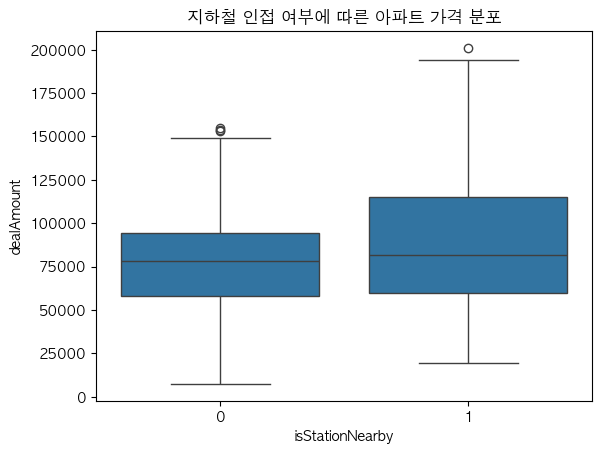

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

# 박스플롯: 지하철 여부별 거래금액
sns.boxplot(x='isStationNearby', y='dealAmount', data=df)
plt.title('지하철 인접 여부에 따른 아파트 가격 분포')
plt.show()


In [139]:
# 지하철 여부별 평균, 중앙값
price_by_subway = df.groupby('isStationNearby')['dealAmount'].agg(['mean', 'median', 'count'])
print(price_by_subway)


                         mean   median  count
isStationNearby                              
0                80163.820809  78000.0    173
1                86933.828996  81500.0    269


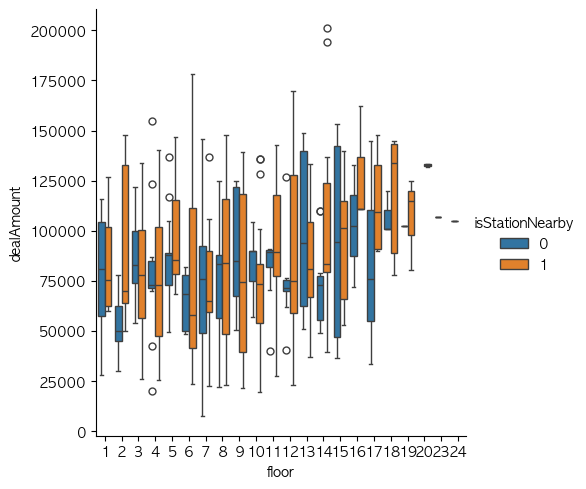

In [140]:
#지하철 여부 + 층수 = 가격 변화
sns.catplot(x='floor', y='dealAmount', hue='isStationNearby', data=df, kind='box')


<Axes: xlabel='area_bin', ylabel='dealAmount'>

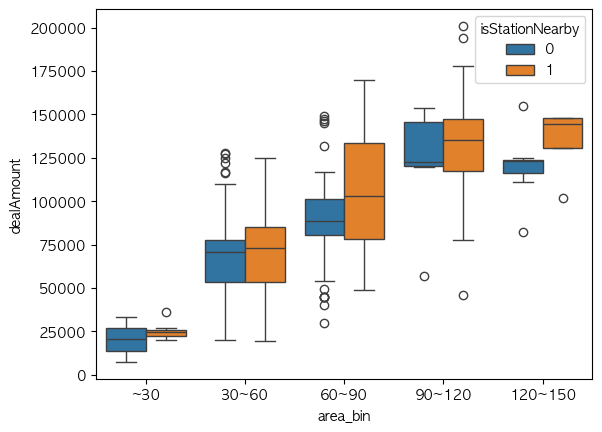

In [141]:
# 지하철 여부 + 전용면적 구간화
df['area_bin'] = pd.cut(df['excluUseAr'], bins=[0, 30, 60, 90, 120, 150], labels=['~30', '30~60', '60~90', '90~120', '120~150'])
sns.boxplot(x='area_bin', y='dealAmount', hue='isStationNearby', data=df)


In [143]:
df.isna().sum()

aptDong                  0
aptNm                    0
buildYear                0
buyerGbn                 0
cdealDay                 0
cdealType                0
dealAmount               0
dealDay                  0
dealMonth                0
dealYear                 0
dealingGbn               0
estateAgentSggNm         0
excluUseAr               0
floor                    0
jibun                    0
landLeaseholdGbn         0
rgstDate                 0
sggCd                    0
slerGbn                  0
umdNm                    0
buildingAge              0
isHighFloor              0
dealYearMonth            0
dealQuarter              0
estateAgentSggNmClean    0
aptAddress               0
aptLat                   0
aptLng                   0
isStationNearby          0
area_bin                 3
dtype: int64

In [144]:
df = df.dropna(subset=['area_bin'])

In [145]:
features = ['excluUseAr', 'floor', 'buildingAge', 'umdNm',
            'isHighFloor', 'isStationNearby']
train_compare_models(df, features)

LinearRegression → MAE: 13890.48, R²: 0.7269
RandomForest → MAE: 5562.41, R²: 0.9194
XGBoost → MAE: 4925.37, R²: 0.9236
LightGBM → MAE: 4912.25, R²: 0.9318


(              Model           MAE        R2
 0  LinearRegression  13890.478931  0.726876
 1      RandomForest   5562.413806  0.919371
 2           XGBoost   4925.366699  0.923605
 3          LightGBM   4912.246366  0.931794,
 {'LinearRegression': LinearRegression(),
  'RandomForest': RandomForestRegressor(random_state=42),
  'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_stra

In [146]:
df.dtypes

aptDong                    object
aptNm                      object
buildYear                   int64
buyerGbn                   object
cdealDay                   object
cdealType                  object
dealAmount                  int64
dealDay                     int64
dealMonth                   int64
dealYear                    int64
dealingGbn                 object
estateAgentSggNm           object
excluUseAr                float64
floor                       int64
jibun                      object
landLeaseholdGbn           object
rgstDate                   object
sggCd                       int64
slerGbn                    object
umdNm                      object
buildingAge                 int64
isHighFloor                 int64
dealYearMonth              object
dealQuarter                 int64
estateAgentSggNmClean      object
aptAddress                 object
aptLat                    float64
aptLng                    float64
isStationNearby             int64
area_bin      

In [147]:
df_numeric = clean_numeric_df(df)
df_numeric.head(3)

,dealAmount,excluUseAr,floor,buildingAge,dealQuarter,isStationNearby,isHighFloor
0,110000,85.00,14,22,1,0,0
1,56991,117.69,7,28,1,0,0
2,73000,49.50,4,33,1,1,0


In [148]:
# 상관관계 계산 전에 dealQuarter 제거
df_numeric = df_numeric.drop(columns = ['dealQuarter'])

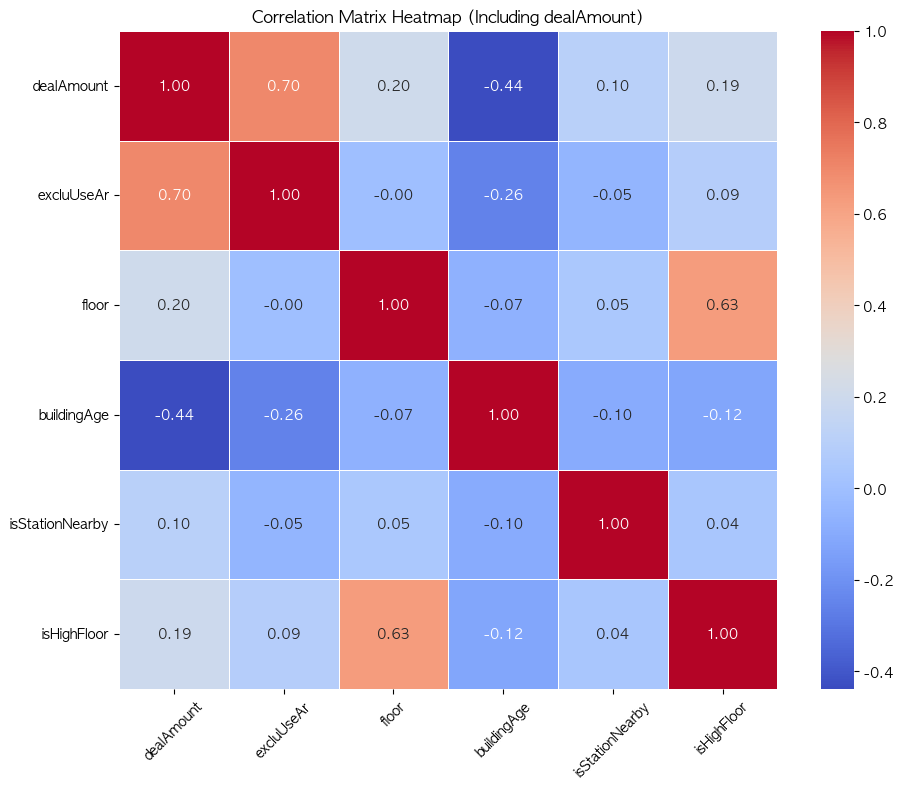

dealAmount         1.000000
excluUseAr         0.696780
floor              0.204114
isHighFloor        0.193749
isStationNearby    0.103165
buildingAge       -0.438616
Name: dealAmount, dtype: float64


In [149]:
plot_dealamount_correlation(df_numeric)

오히려 이전 지하철관련 추가를 안한 모델에서 더 좋은 MAE와 r2값이 나왔다. \
일단 역세권 여부에서 역세권인 집이 하나밖에 없어서 지역을 바꿔봐야겠다

지역을 강서구로 바꿔서 진행해 보았는데 전체적으로 R2값이 높게 나와서 과적합 여부를 판단해야 될 것으로 보임 \
반면 MAE는 이전에 비해서 괜찮은 값이 나온 것 같음. \
하지만 모델에서는 비교적 역세권이 집 값이 조금 더 높은 편이었다면 \
상관관계를 비교해 보았을 때는 역세권 여부에는 많은 영향을 미치지 않는 것으로 보인다. \
역세권 여부 컬럼을 넣었지만 변수 중요도는 높지 않았다. \
하지만 이 컬럼을 넣은 후 모델에서의 성능은 굉장히 높아졌다. \
역세권 컬럼이 보조적으로 미세한 영향을 준 것으로 판단. \
이제 학군데이터를 추가해서 비교해볼 예정이다.


아래는 df['subwayDistance']를 제외하고 df['isStaionNearby']만 넣었던 데이터인데 오히려 결과가 더 좋게 나왔다

In [61]:
# LightGBM 과적합 여부 판단
# 모델 학습
result_df, models, X_train, X_valid, y_train, y_valid = train_compare_models(df, features)

# LightGBM 모델 성능 확인
model = models['LightGBM']
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_valid = mean_absolute_error(y_valid, y_valid_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_valid = r2_score(y_valid, y_valid_pred)

print(f"[TRAIN] MAE: {mae_train:.2f}, R²: {r2_train:.4f}")
print(f"[VALID] MAE: {mae_valid:.2f}, R²: {r2_valid:.4f}")


LinearRegression → MAE: 13301.28, R²: 0.6809
RandomForest → MAE: 6012.38, R²: 0.8907
XGBoost → MAE: 5504.99, R²: 0.8883
LightGBM → MAE: 5363.41, R²: 0.9090
[TRAIN] MAE: 1281.24, R²: 0.9966
[VALID] MAE: 5363.41, R²: 0.9090


실제데이터와 예측데이터를 비교해본 결과 \
R2 값은 valid_data가 0.9 이상이므로 이정도면 인용이 가능해보임 \
MAE값은 valid_data와 train_data가 4배 가량 차이가 나고 dealAmount 단위가 만원단위기 때문에 \
5363만원의 오차가 있다는 것이다. 예측력은 나쁘지 않지만 오차가 크다고 판단되어 \
학군 데이터를 추가적으로 피처엔지니어링 하려고한다.

In [62]:
from base_model_utils import preprocess_base_df
df = preprocess_base_df(df)
df.to_csv('02_add_subway_df.csv', index=False)